# Crossmatch inspection notebook

You will need to install psycopg2 and astroquery.

This notebook looks for all the objects that have a crossmatch label, which can be useful for understanding training set representativity and detecting wrong crossmatches

### Load libraries

*External dependencies*:

psycopg2: pip install psycopg2-binary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from astroquery.ned import Ned # pip install astroquery
import astropy.units as u
from astropy import coordinates

In [29]:
XMATCH_TABLE = [
    'OTHER',
    'CEPH',
    'DSCT',
    'EB',
    'LPV',
    'RRL',
    'SNE'
]

### Get credentials (not in github repository)

In [2]:
import json
credentials_file = "../alerceuser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [3]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
cur = conn.cursor()

### Show all the available tables

In [4]:
query = "select tablename from pg_tables where schemaname='public';"

cur.execute(query)
tables = cur.fetchall()

print(tables)

[('class',), ('asassn',), ('crtsnorth',), ('crtssouth',), ('detections',), ('objects',), ('probabilities',), ('xmatch',), ('features',), ('linear',), ('tns',), ('magref',), ('non_detections',), ('tmp',)]


### For each table, show column names and column types

In [24]:
dftab = pd.DataFrame()
for tab in tables:
    cols = pd.DataFrame()
    query = "select column_name from information_schema.columns where table_name = '%s';" % tab
    cur.execute(query)
    results = cur.fetchall()
    if len(results) > 0:
        cols["table"] = [tab[0] for i in results]
        cols["name"] = [res[0] for res in results]
        query = "select data_type from information_schema.columns where table_name = '%s';" % tab
        cur.execute(query)
        cols["dtype"] = [dt[0] for dt in cur.fetchall()]
        dftab = pd.concat([dftab, cols])
pd.options.display.max_rows = 999
display(dftab)
pd.options.display.max_rows = 101

,table,name,dtype
0,class,id,integer
1,class,name,character varying
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision


### Function to query data more easily

In [5]:
def sql_query(query):
    cur.execute(query)
    result = cur.fetchall()
    
    # Extract the column names
    col_names = []
    for elt in cur.description:
        col_names.append(elt[0])

    #Convert to dataframe
    df = pd.DataFrame(np.array(result), columns = col_names)
    return(df)

### Query objects with xmatch label and more than 10 detections

In [96]:
query='''
select objects.oid, objects.classxmatch, 
objects.nobs, objects.meanra, 
objects.meandec, features.periodls_1, features.periodls_2


from objects inner join features on objects.oid=features.oid

where objects.classxmatch is not null and objects.nobs > 10
'''

xmatched_sources = sql_query(query)

In [98]:
count = xmatched_sources.groupby('classxmatch').count()
for i in range(7):
    print(XMATCH_TABLE[i], count.iloc[i]['oid'])
print(xmatched_sources.columns)

OTHER 739
CEPH 351
DSCT 458
EB 18862
LPV 1856
RRL 11463
SNE 460
Index(['oid', 'classxmatch', 'nobs', 'meanra', 'meandec', 'periodls_1',
       'periodls_2'],
      dtype='object')


### Visualize random object

In [179]:
def get_lc_data(oid, doplot = False, doNED = False):
    # detections
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    detections = sql_query(query)
    for col in list(detections):
        if col != 'oid':
            detections[col] = pd.to_numeric(detections[col], errors = 'ignore')
        
    # non detections
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    non_detections = sql_query(query)
    for col in list(non_detections):
        if col != 'oid':
            non_detections[col] = pd.to_numeric(non_detections[col], errors = 'ignore')
    
    # sort by date
    detections.sort_values(by='mjd', inplace=True)
    non_detections.sort_values(by='mjd', inplace=True)
    
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=xmatched_sources.meanra[xmatched_sources.oid == oid], 
                                  dec=xmatched_sources.meandec[xmatched_sources.oid == oid], 
                                  unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
    
    # plot
    if doplot:
        classxmatch = xmatched_sources['classxmatch'][xmatched_sources.oid == oid].values[0]
        classxmatch = XMATCH_TABLE[int(classxmatch)]
        fig, ax = plt.subplots(figsize = (14, 7))
        labels = {1: 'g', 2: 'r'}
        colors = {1: 'g', 2: 'r'}
        for fid in [1, 2]:
            mask = detections.fid == fid
            ax.errorbar(detections[mask].mjd, detections[mask].magpsf_corr, 
                yerr = detections[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
            mask = (non_detections.fid == fid) & (non_detections.diffmaglim > -900)
            ax.scatter(non_detections[mask].mjd, non_detections[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                        marker = 'v', label = "lim.mag. %s" % labels[fid])
        ax.set_title('oid: %s, xmatch class: %s' % (oid, classxmatch))
        ax.set_xlabel("MJD")
        ax.set_ylabel("Magnitude")
        ax.legend()
        ax.set_ylim(ax.get_ylim()[::-1])
        
        period_1 = float(xmatched_sources['periodls_1'][xmatched_sources.oid == oid].values[0])
        period_2 = float(xmatched_sources['periodls_2'][xmatched_sources.oid == oid].values[0])
        
        period_mean = (period_1 + period_2) / 2
        diff = abs(period_1-period_2)/period_mean
        if diff < 0.1:
            fig, ax = plt.subplots(figsize=(14, 7))
            for fid in [1, 2]:
                mask = detections.fid == fid
                ax.errorbar((detections[mask].mjd % period_mean)/period_mean, detections[mask].magpsf_corr,
                            yerr = detections[mask].sigmapsf_corr, c = colors[fid], marker = 'o', 
                            label = labels[fid], linestyle='')
            ax.set_title('oid: %s, xmatch class: %s, folded with period %.3f' % (oid, classxmatch, period_mean))
            ax.set_xlabel("MJD")
            ax.set_ylabel("Magnitude")
            ax.legend()
            ax.set_ylim(ax.get_ylim()[::-1])
        
        
    # return data
    return detections, non_detections

### Select class

In [180]:
object_class = 'CEPH'
subset = xmatched_sources[xmatched_sources.classxmatch == str(XMATCH_TABLE.index(object_class))]

ZTF18aaveeue


No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,2MASS J19325484+1928498,293.22858,19.48051,IrS,--,--,,,0.571,0,0,13,2,0,0,0
2,2MASS J19325531+1928589,293.2305,19.48306,IrS,--,--,,,0.488,0,0,4,1,0,0,0
3,2MASS J19325541+1928425,293.2309,19.4785,IrS,--,--,,,0.456,0,0,5,1,0,0,0
4,2MASS J19325547+1928586,293.23124,19.48293,IrS,--,--,,,0.445,0,0,11,2,0,0,0
5,2MASS J19325560+1929092,293.23168,19.48589,IrS,--,--,,,0.511,0,0,5,1,0,0,0
6,2MASS J19325567+1928514,293.23199,19.4809,IrS,--,--,,,0.379,0,0,16,2,0,0,0
7,2MASS J19325589+1928434,293.23285,19.47873,IrS,--,--,,,0.346,0,0,16,2,0,0,0
8,2MASS J19325601+1929061,293.23341,19.48503,IrS,--,--,,,0.404,0,0,4,1,0,0,0


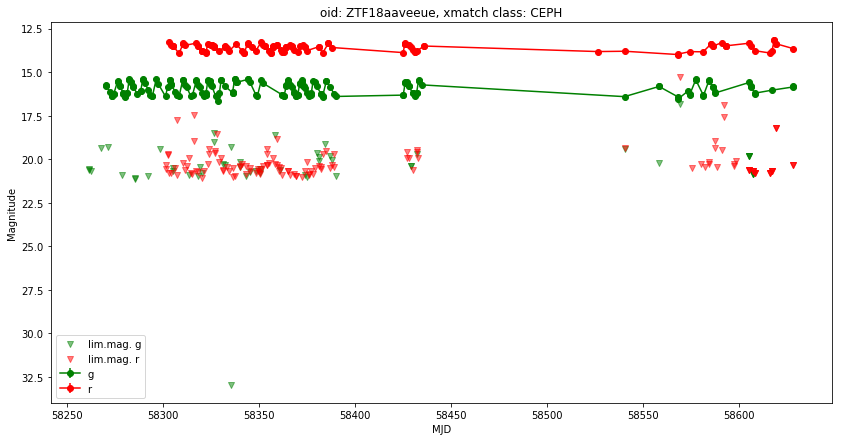

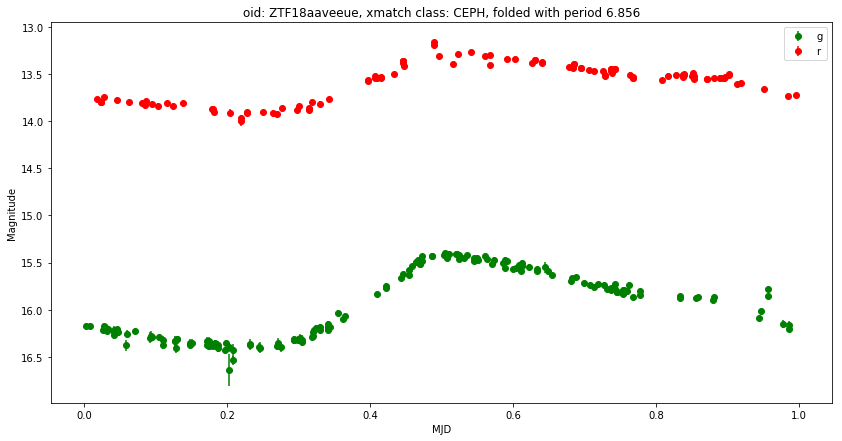

In [184]:
random_oid = subset['oid'].iloc[np.random.randint(len(subset))]
print(random_oid)
detections, non_detections = get_lc_data(random_oid, doplot=True, doNED=True);